# Intro

This project analyzes daily stock market data to visualize how the Overnight Drift and Intraday Drift contribute to the overall change in the stock price.

## Install Dependencies

Install dependencies quietly, so logs don’t reveal sensitive info like absolute paths or user-specific details.

In [1]:
%pip install pandas polygon-api-client matplotlib -qq

Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime
from polygon import RESTClient
import matplotlib.pyplot as plt
import pandas as pd

## Get Daily Aggregates

Use Polygon.io REST API to get daily aggregated bars. Docs: https://github.com/polygon-io/client-python

In [9]:
API_KEY = "<insert API key here>"

In [4]:
client = RESTClient(api_key=API_KEY)

In [5]:
def list_daily_aggregates(symbol, start_date, end_date):
    aggs = []
    for a in client.list_aggs(ticker=symbol, multiplier=1, timespan="day", from_=start_date, to=end_date, limit=50000):
        aggs.append(a)
    return aggs

def get_bars_as_dataframe(aggs):
    bars = pd.DataFrame([{
        "timestamp": a.timestamp,
        "open": a.open,
        "high": a.high,
        "low": a.low,
        "close": a.close,
        "volume": a.volume,
        "vwap": a.vwap,
        "transactions": a.transactions
    } for a in aggs])

    # Convert timestamp to datetime and set as index
    bars["date"] = pd.to_datetime(bars["timestamp"], unit="ms")
    bars.set_index("date", inplace=True)
    bars.drop(columns=["timestamp"], inplace=True)

    return bars.sort_index()

## Calculate Overnight and Intraday Drift

This code calculates the __Overnight Drift__ and __Intraday Drift__ for each trading day. The cumulative products for the __Overnight Drift__ and the __Intraday Drift__ are calculated independently of one another, while the __Total Drift__ can be understood as a relationship between the effect caused by the __Overnight Drift__ and the __Intraday Drift__ together. __Total Drift__ is the same statistic used in other charts to describe the stock price's _total change_ over a period of time (e.g. "YTD", "1M", "3M", etc.)

The __Combined Magnitude__ is the magnitude of the __Overnight Drift__ added with the magnitude of the __Intraday Drift__, as a way to represent the overall combined volatility in the stock price. The individual contribution that __Overnight Drift__ and __Intraday Drift__ make to this combined magnitude are also calculated.

$$
\text O_t = \text{Opening Price on day } t
$$

$$
\text C_t = \text{Closing Price on day } t
$$
 
$$
\text{Overnight Drift}_t = \frac{O_t - C_{t-1}}{C_{t-1}}
$$

$$
\text{Cumulative Overnight Drift}_t = \prod_{i=1}^{t} \left(1 + \text{Overnight Drift}_t\right) - 1
$$

$$
\text{Intraday Drift}_t = \frac{C_t - O_t}{O_t}
$$

$$
\text{Cumulative Intraday Drift}_t = \prod_{i=1}^{t} \left(1 + \text{Intraday Drift}_t\right) - 1
$$

$$
\text{Total Drift}_t = \left(1 + \text{Overnight Drift}_t\right)\left(1 + \text{Intraday Drift}_t\right) - 1 \qquad \left(i.e. \frac{C_t - C_{t-1}}{C_{t-1}}\right)
$$

$$
\text{Cumulative Total Drift}_t = \prod_{i=1}^{t} \left(1 + \text{Total Drift}_t\right) - 1
$$

$$
\\
$$

$$
\text{Combined Magnitude}_t = \left|\text{Overnight Drift}_t\right| + \left|\text{Intraday Drift}_t\right|
$$

$$
\text{Overnight Drift Contribution}_t = \frac{\left|\text{Overnight Drift}_t\right|}{\text{Combined Magnitude}_t}
$$

$$
\text{Intraday Drift Contribution}_t = \frac{\left|\text{Intraday Drift}_t\right|}{\text{Combined Magnitude}_t}
$$

In [6]:
def calculate_overnight_drift(bars):
    # Overnight Drift = Today's Open - Yesterday's Close) / Yesterday's Close
    bars["overnight_drift"] = (bars["open"] - bars["close"].shift(1)) / bars["close"].shift(1) * 100

    # Cumulative Overnight Drift = Yesterday's Cumulative Overnight Drift * Today's Overnight Drift
    bars["cumulative_overnight_drift"] = ((1 + bars["overnight_drift"] / 100).cumprod() - 1) * 100

    return bars

def calculate_intraday_drift(bars):
    # Intraday Drift = (Today's Close - Today's Open) / Today's Open
    bars["intraday_drift"] = (bars["close"] - bars["open"]) / bars["open"] * 100

    # Cumulative Intraday Drift = Yesterday's Cumulative Intraday Drift * Today's Intraday Drift
    bars["cumulative_intraday_drift"] = ((1 + bars["intraday_drift"] / 100).cumprod() - 1) * 100
    
    return bars

def calculate_total_drift(bars):
    # Total Drift = ((1 + Overnight Drift) * (1 + Intraday Drift)) - 1
    bars["total_drift"] = ((1 + bars["overnight_drift"] / 100) * (1 + bars["intraday_drift"] / 100) - 1) * 100

    #     ...     = (Today's Close - Yesterday's Close) / Yesterday's Close  <- conceptually this is the same thing 
    #bars["total_drift"] = (bars["close"] - bars["close"].shift(1)) / bars["close"].shift(1) * 100

    # Cumulative Total Drift = Yesterday's Cumulative Total Drift * Today's Total Drift (%)
    bars["cumulative_total_drift"] = ((1 + bars["total_drift"]/100).cumprod() - 1) * 100

    return bars

def calculate_contribution_to_combined_magnitude_of_drifts(bars):
    # Combined Magnitude = |Overnight Drift| + |Intraday Drift|

    # Overnight Drift Contribution = |Overnight Drift| / (|Overnight Drift| + |Intraday Drift|)
    bars["overnight_drift_contribution"] = (bars["overnight_drift"].abs() / (bars["overnight_drift"].abs() + bars["intraday_drift"].abs())) * 100

    # Intraday Drift Contribution = |Intraday Drift| / (|Overnight Drift| + |Intraday Drift|)
    bars["intraday_drift_contribution"] = (bars["intraday_drift"].abs() / (bars["overnight_drift"].abs() + bars["intraday_drift"].abs())) * 100

    return bars


## Plot Overnight and Intraday Drift


In [7]:
def plot_colored_line(ax, x, y):
    # Plot line segments: color green for positive values, color red for negative values
    for i in range(len(x) - 1):
        x0, x1 = x[i], x[i+1]
        y0, y1 = y[i], y[i+1]

        # If line segment crosses below y=0, split it
        if y0 * y1 < 0:
            # Linear interpolation to find x where y=0
            x_cross = x0 + ((x1 - x0) * (abs(y0) / (abs(y0) + abs(y1))))

            # Plot first sub-segment
            ax.plot([x0, x_cross], [y0, 0], color="green" if y0 > 0 else "red", lw=2)

            # Plot second sub-segment
            ax.plot([x_cross, x1], [0, y1], color="green" if y1 > 0 else "red", lw=2)
        else:
            # Else, plot full segment
            ax.plot([x0, x1], [y0, y1], color="green" if y1 > 0 else "red", lw=2)

    # Fill area underneath the curve: color green for positive values, color red for negative values
    ax.fill_between(x, 0, y, where=(y >= 0), color="green", alpha=0.2, interpolate=True)
    ax.fill_between(x, 0, y, where=(y < 0), color="red", alpha=0.2, interpolate=True)
    
    return ax

def plot_overnight_drift(symbol, bars):

    plt.figure(figsize=(12, 8))

    # Plot Overnight Drift
    ax1 = plt.subplot(2, 1, 1)
    green_or_red = ["green" if val > 0 else "red" for val in bars["overnight_drift"]]
    ax1.bar(bars.index, bars["overnight_drift"], color=green_or_red)
    ax1.axhline(0, color="black", linewidth=1)
    ax1.set_ylabel("Overnight Drift (%)")
    ax1.set_title("{} - Overnight Drift".format(symbol))

    # Plot Cumulative Overnight Drift
    ax2 = plt.subplot(2, 1, 2)
    ax2 = plot_colored_line(ax2, bars.index, bars["cumulative_overnight_drift"].values)
    ax2.axhline(0, color="black", linewidth=1)
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Cumulative Overnight Drift (%)")
    ax2.set_title("{} - Cumulative Overnight Drift".format(symbol))

    plt.tight_layout()
    plt.show()

def plot_intraday_drift(symbol, bars):

    plt.figure(figsize=(12, 8))

    # Plot Intraday Drift
    ax1 = plt.subplot(2, 1, 1)
    green_or_red = ["green" if val > 0 else "red" for val in bars["intraday_drift"]]
    ax1.bar(bars.index, bars["intraday_drift"], color=green_or_red)
    ax1.axhline(0, color="black", linewidth=1)
    ax1.set_ylabel("Intraday Drift (%)")
    ax1.set_title("{} - Intraday Drift".format(symbol))

    # Plot Cumulative Intraday Drift
    ax2 = plt.subplot(2, 1, 2)
    ax2 = plot_colored_line(ax2, bars.index, bars["cumulative_intraday_drift"].values)
    ax2.axhline(0, color="black", linewidth=1)
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Cumulative Intraday Drift (%)")
    ax2.set_title("{} - Cumulative Intraday Drift".format(symbol))

    plt.tight_layout()
    plt.show()

def plot_overnight_and_intraday_contribution(symbol, bars):
    # Combined Magnitude = |Overnight Drift| + |Intraday Drift|
    # Plot the contribution that the Overnight Drift and Intraday Drift make to the Combined Magnitude

    plt.figure(figsize=(12, 8))

    # Plot Combined Magnitude
    ax1 = plt.subplot(2, 1, 1)
    ax1.bar(bars.index, bars["overnight_drift"].abs() + bars["intraday_drift"].abs(), color="olive")
    ax1.axhline(0, color="black", linewidth=1)
    ax1.set_ylabel("Combined Magnitude (%)")
    ax1.set_title("{} - Combined Magnitude = |Overnight Drift| + |Intraday Drift|".format(symbol))

    # Plot Overnight Drift vs. Intraday Drift Contribution to Combined Magnitude
    ax2 = plt.subplot(2, 1, 2)
    ax2.bar(bars.index, bars["overnight_drift_contribution"], color="blue", label="Overnight Drift Contribution (%)")
    ax2.bar(bars.index, bars["intraday_drift_contribution"], bottom=bars["overnight_drift_contribution"], color="orange", label="Intraday Drift Contribution (%)")
    ax2.axhline(0, color="black", linewidth=1)
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Contribution to Combined Magnitude (%)")
    ax2.set_title("{} - Overnight Drift vs. Intraday Drift Contribution to Combined Magnitude".format(symbol))
    ax2.legend()

    plt.tight_layout()
    plt.show()

def print_stats(symbol, bars):
    
    print("-" * 125)
    
    print("Symbol: {}".format(symbol))

    print("\n")
    print("Start Date: {}".format(bars.index[0].date()))
    print("End Date: {}".format(bars.index[-1].date()))

    print("\n")
    print("Max Overnight Drift: {:.6f}%".format(bars["overnight_drift"].loc[bars["overnight_drift"].abs().idxmax()]))
    print("Max Intraday Drift: {:.6f}%".format(bars["intraday_drift"].loc[bars["intraday_drift"].abs().idxmax()]))

    print("\n")
    cod = bars["cumulative_overnight_drift"].iloc[-1]
    cid = bars["cumulative_intraday_drift"].iloc[-1]
    print("Cumulative Overnight Drift (as of End Date): {:.6f}%".format(cod))
    print("Cumulative Intraday Drift (as of End Date): {:.6f}%".format(cid))

    print("\n")
    tc = (bars["close"].iloc[-1] / bars["close"].iloc[0] - 1) * 100
    print("Total Change (Start Date's Close vs. End Date's Close): {:.6f}%".format(tc))
    print("Cumulative Overnight Drift + Cumulative Intraday Drift: {:.6f}%".format(cod + cid))
    print("Difference between Total Change and (Cumulative Overnight Drift + Cumulative Intraday Drift): {:.6f}%".format(tc - (cod + cid)))

    print("\n")
    ctd = bars["cumulative_total_drift"].iloc[-1]
    print("Cumulative Total Drift: {:.6f}%".format(ctd))
    print("Difference between Total Change and Cumulative Total Drift: {:.6f}%".format(tc - ctd))

    print("-" * 125) 
    

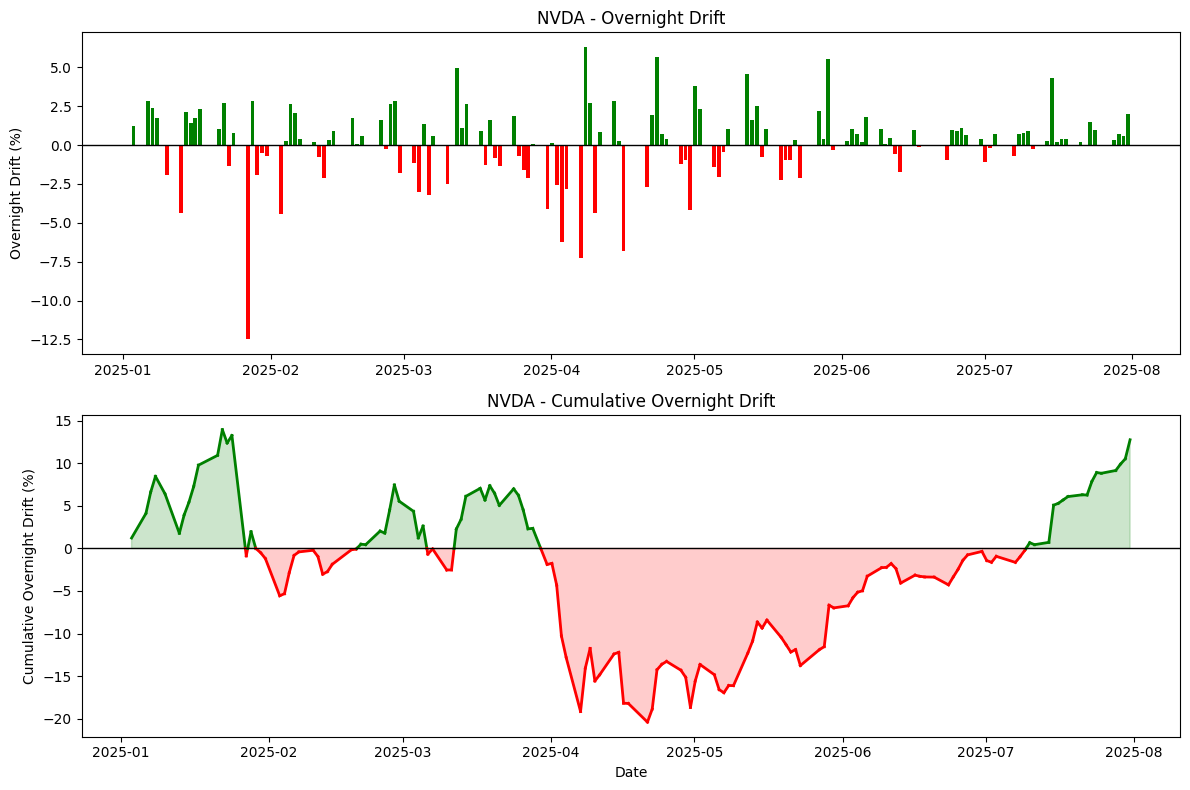

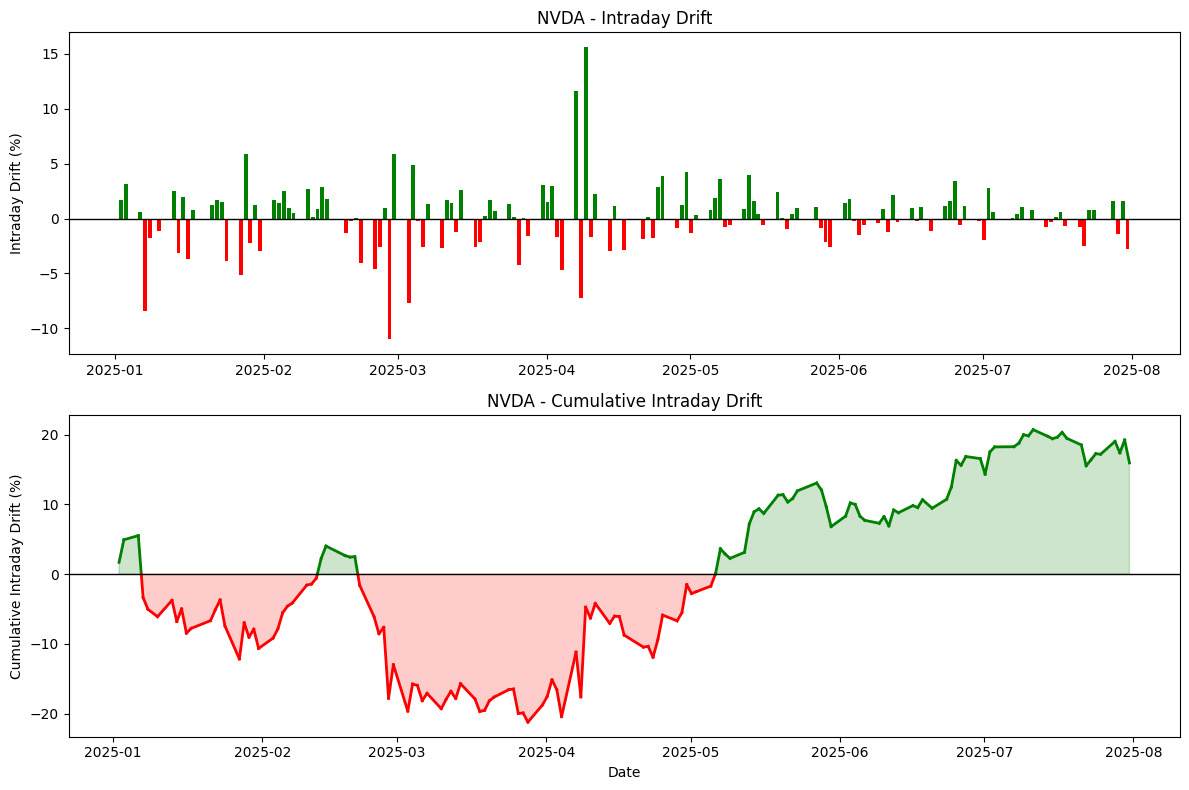

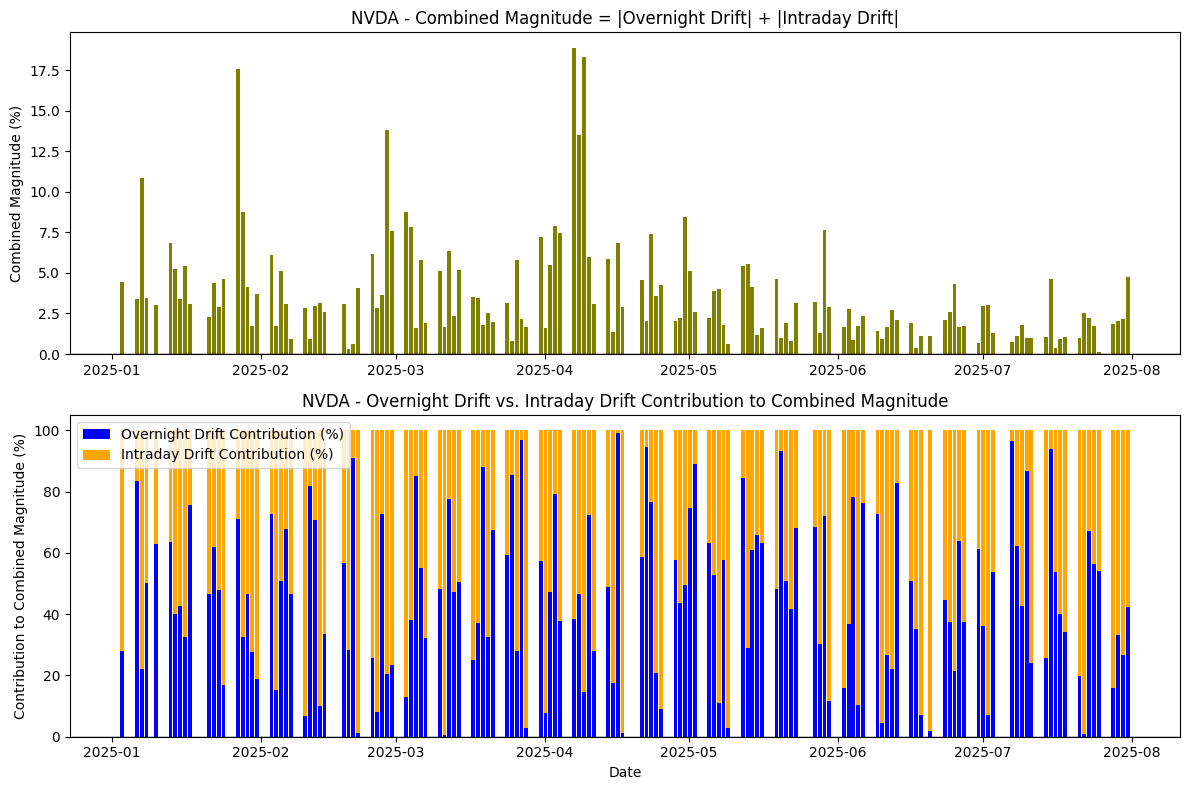

-----------------------------------------------------------------------------------------------------------------------------
Symbol: NVDA


Start Date: 2025-01-02
End Date: 2025-07-31


Max Overnight Drift: -12.494741%
Max Intraday Drift: 15.613308%


Cumulative Overnight Drift (as of End Date): 12.781856%
Cumulative Intraday Drift (as of End Date): 15.964367%


Total Change (Start Date's Close vs. End Date's Close): 28.602415%
Cumulative Overnight Drift + Cumulative Intraday Drift: 28.746222%
Difference between Total Change and (Cumulative Overnight Drift + Cumulative Intraday Drift): -0.143808%


Cumulative Total Drift: 28.602415%
Difference between Total Change and Cumulative Total Drift: 0.000000%
-----------------------------------------------------------------------------------------------------------------------------


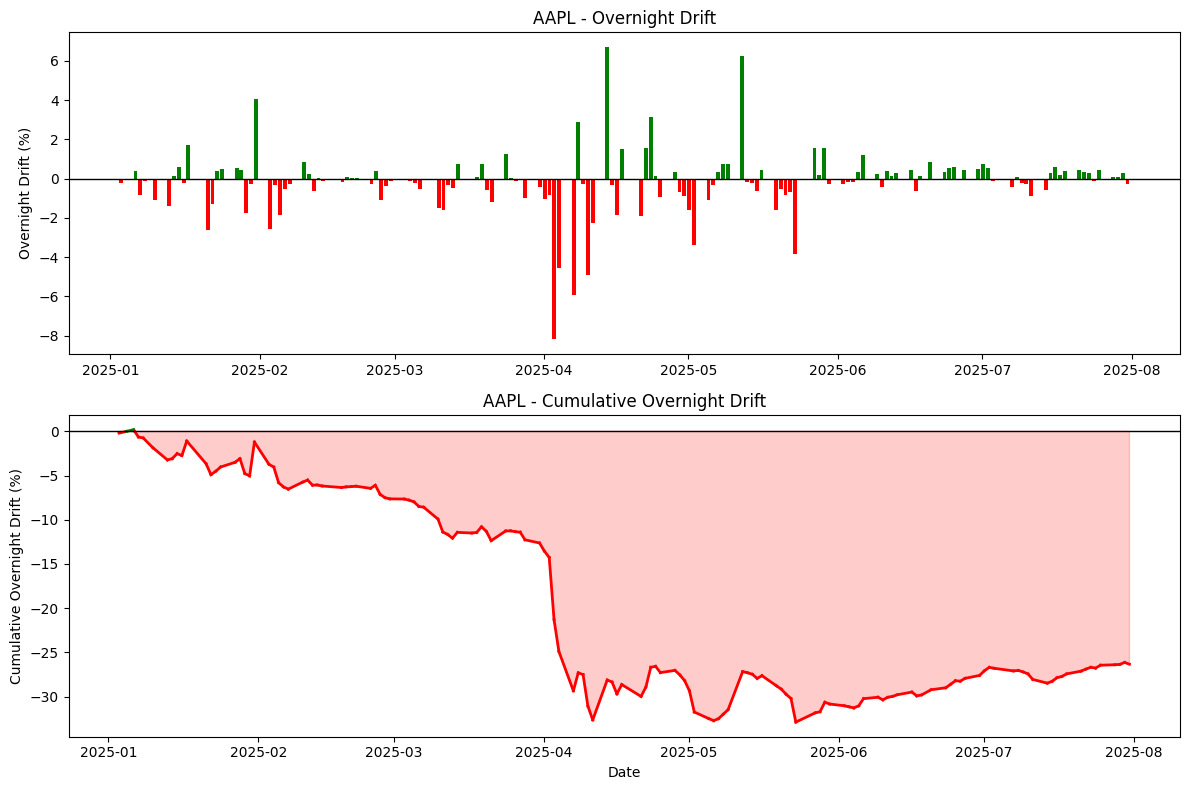

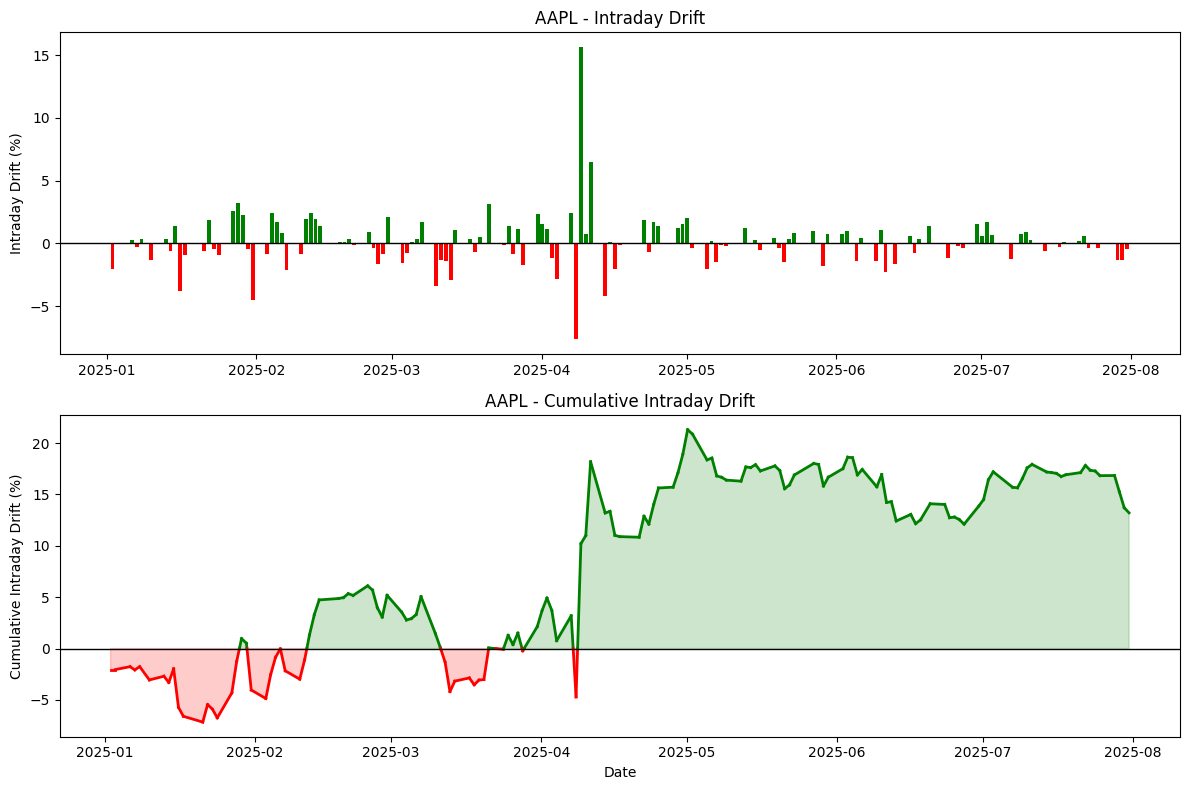

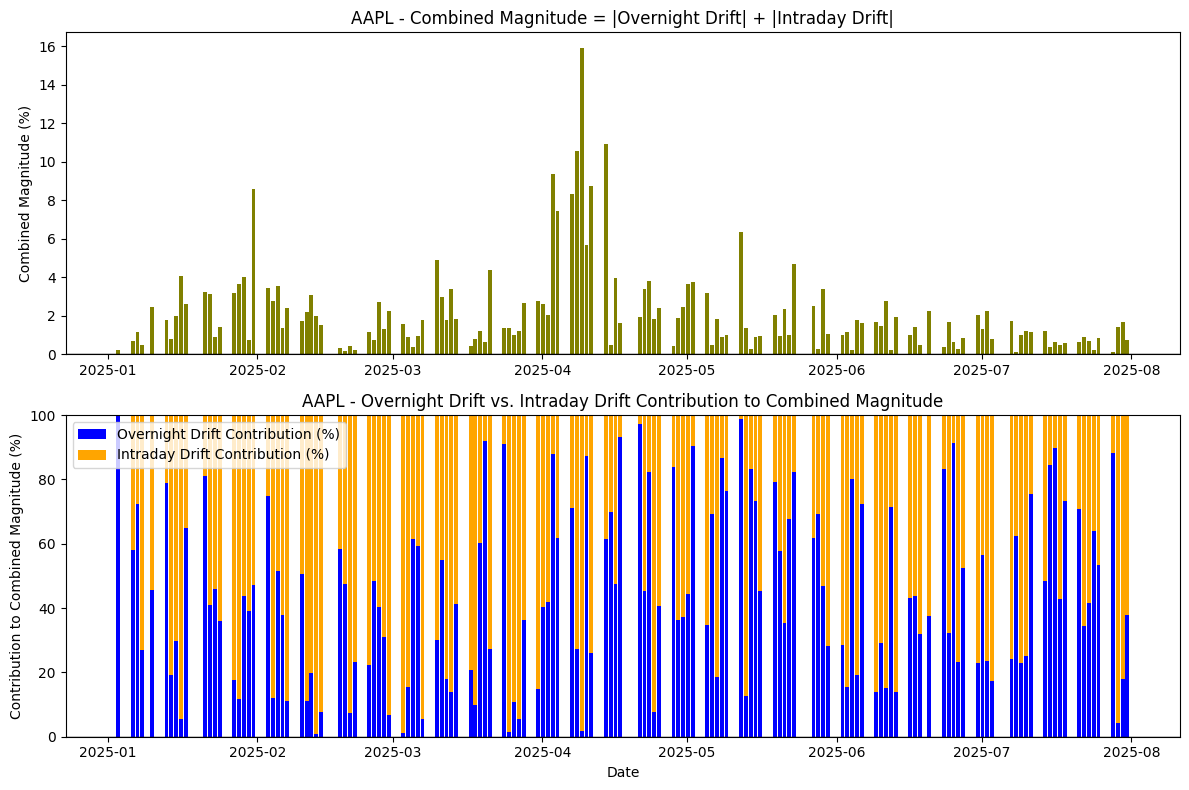

-----------------------------------------------------------------------------------------------------------------------------
Symbol: AAPL


Start Date: 2025-01-02
End Date: 2025-07-31


Max Overnight Drift: -8.195989%
Max Intraday Drift: 15.644083%


Cumulative Overnight Drift (as of End Date): -26.342491%
Cumulative Intraday Drift (as of End Date): 13.206228%


Total Change (Start Date's Close vs. End Date's Close): -14.877999%
Cumulative Overnight Drift + Cumulative Intraday Drift: -13.136263%
Difference between Total Change and (Cumulative Overnight Drift + Cumulative Intraday Drift): -1.741736%


Cumulative Total Drift: -14.877999%
Difference between Total Change and Cumulative Total Drift: -0.000000%
-----------------------------------------------------------------------------------------------------------------------------


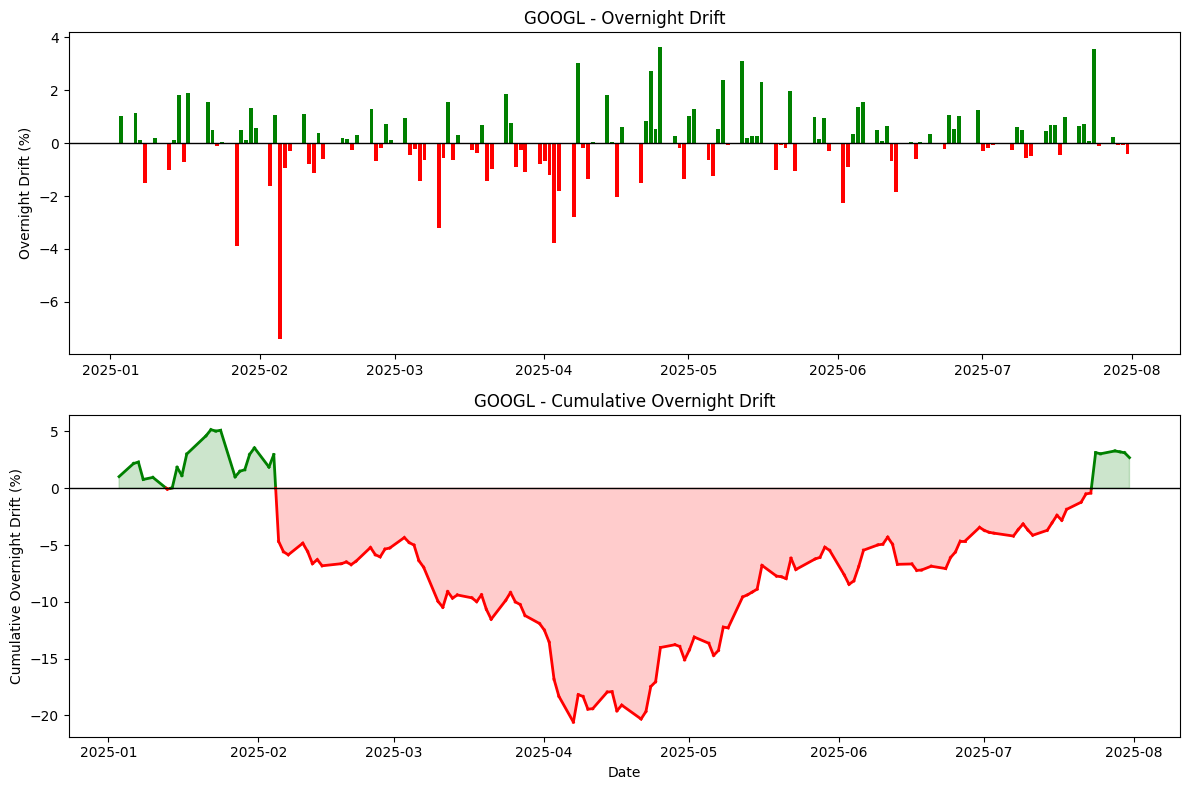

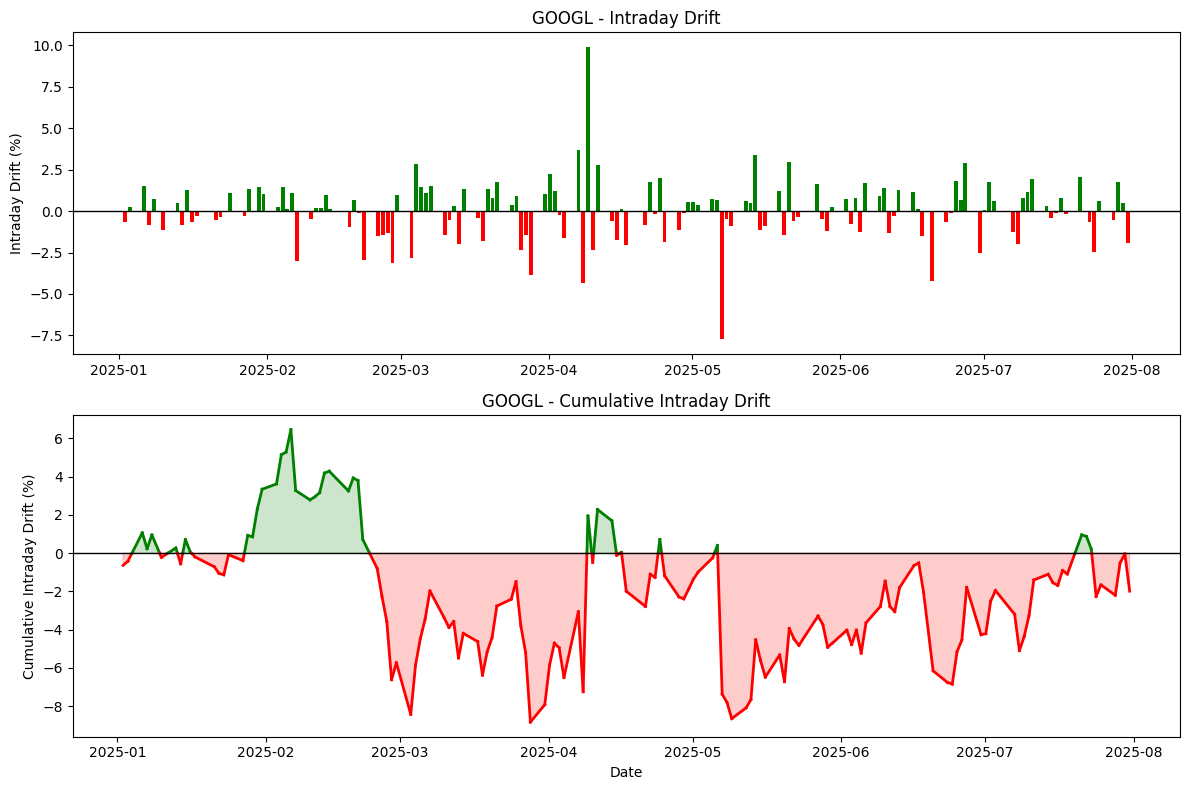

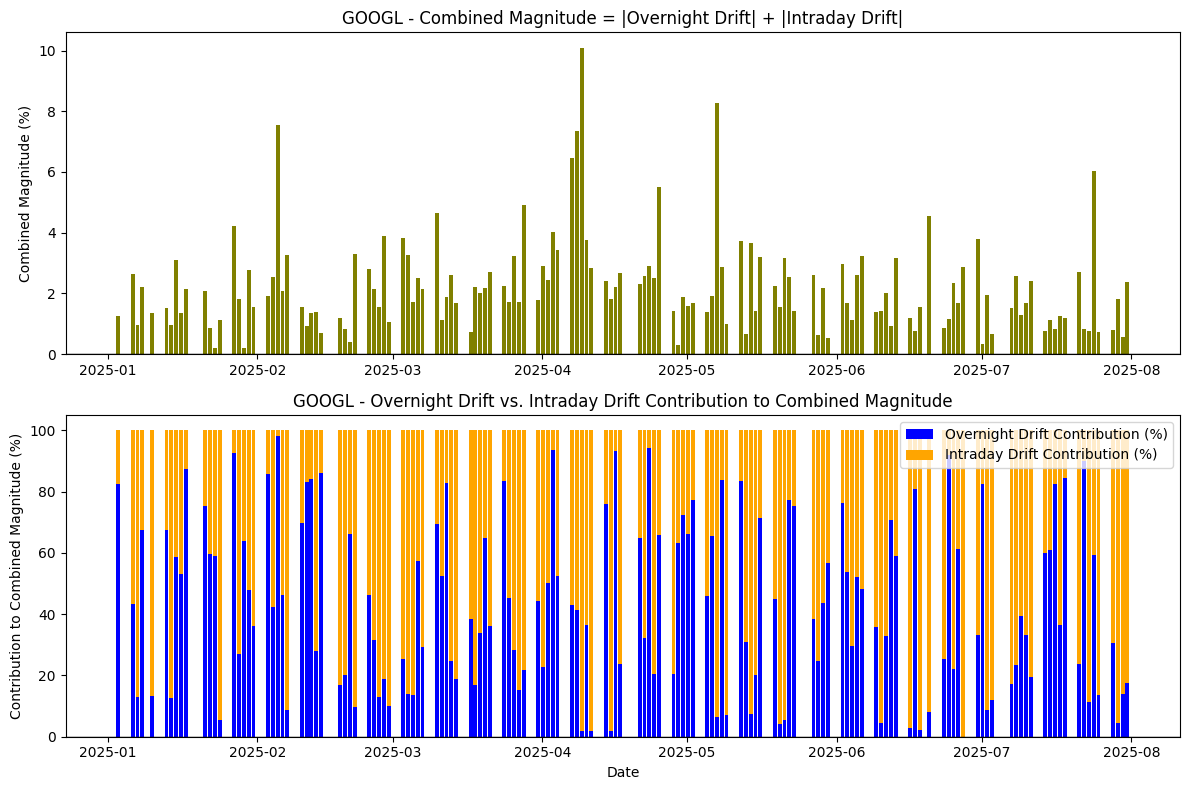

-----------------------------------------------------------------------------------------------------------------------------
Symbol: GOOGL


Start Date: 2025-01-02
End Date: 2025-07-31


Max Overnight Drift: -7.418354%
Max Intraday Drift: 9.898556%


Cumulative Overnight Drift (as of End Date): 2.695486%
Cumulative Intraday Drift (as of End Date): -1.986294%


Total Change (Start Date's Close vs. End Date's Close): 1.303912%
Cumulative Overnight Drift + Cumulative Intraday Drift: 0.709192%
Difference between Total Change and (Cumulative Overnight Drift + Cumulative Intraday Drift): 0.594720%


Cumulative Total Drift: 1.303912%
Difference between Total Change and Cumulative Total Drift: -0.000000%
-----------------------------------------------------------------------------------------------------------------------------


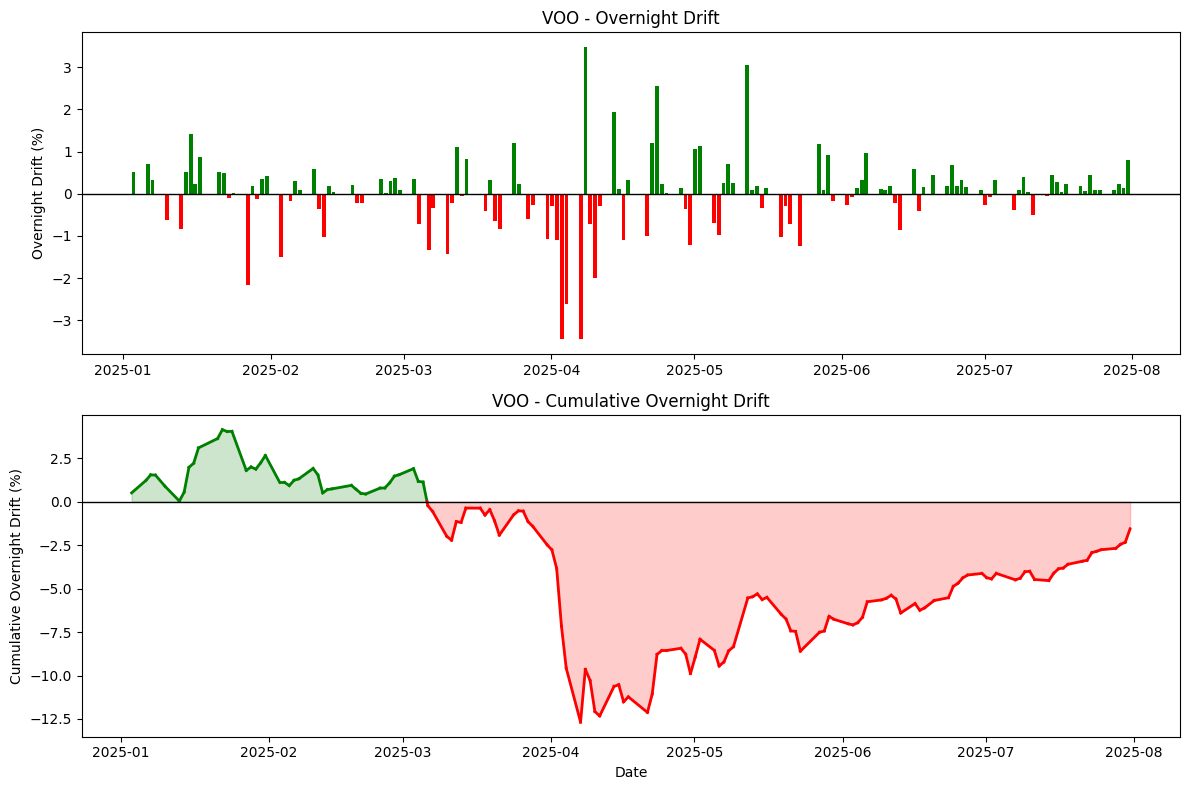

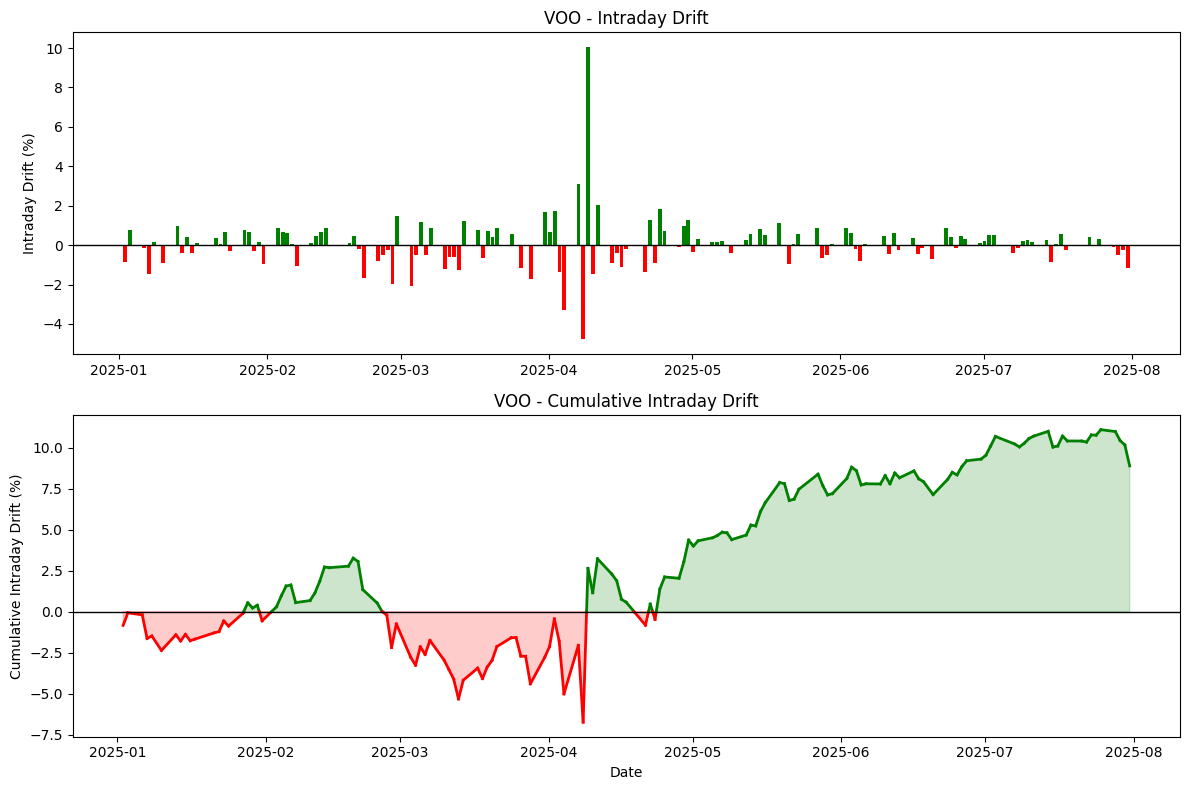

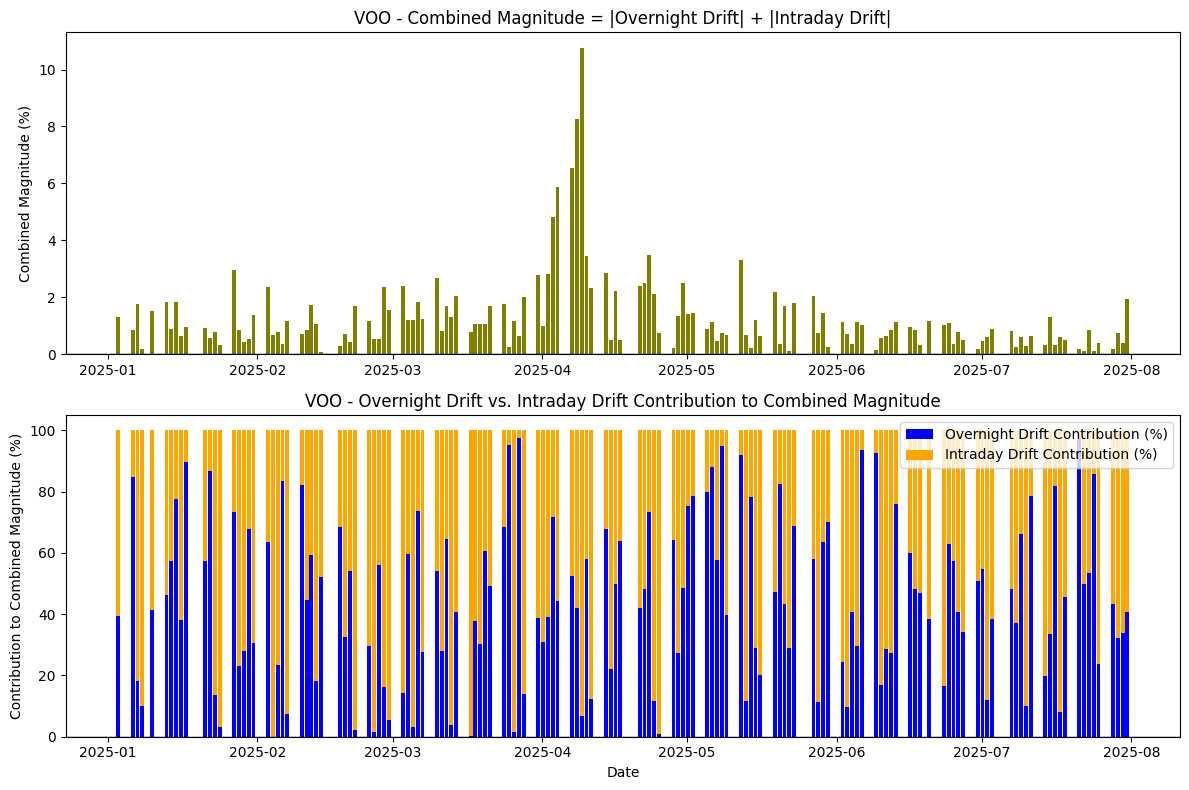

-----------------------------------------------------------------------------------------------------------------------------
Symbol: VOO


Start Date: 2025-01-02
End Date: 2025-07-31


Max Overnight Drift: 3.477435%
Max Intraday Drift: 10.057554%


Cumulative Overnight Drift (as of End Date): -1.556510%
Cumulative Intraday Drift (as of End Date): 8.890193%


Total Change (Start Date's Close vs. End Date's Close): 8.104789%
Cumulative Overnight Drift + Cumulative Intraday Drift: 7.333683%
Difference between Total Change and (Cumulative Overnight Drift + Cumulative Intraday Drift): 0.771106%


Cumulative Total Drift: 8.104789%
Difference between Total Change and Cumulative Total Drift: 0.000000%
-----------------------------------------------------------------------------------------------------------------------------


In [8]:
symbols = ["NVDA", "AAPL", "GOOGL", "VOO"]

for symbol in symbols:
    bars_start_date, bars_end_date = "2025-01-01", "2025-07-31"
    
    aggs = list_daily_aggregates(symbol, bars_start_date, bars_end_date)
    bars = get_bars_as_dataframe(aggs)
    bars = calculate_overnight_drift(bars)
    bars = calculate_intraday_drift(bars)
    bars = calculate_total_drift(bars)
    bars = calculate_contribution_to_combined_magnitude_of_drifts(bars)

    plot_overnight_drift(symbol, bars)
    plot_intraday_drift(symbol, bars)
    plot_overnight_and_intraday_contribution(symbol, bars)

    print_stats(symbol, bars)